In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
from scipy import signal
import matplotlib.pyplot as plt
import random
import json

In [3]:
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
SEQUENCE_NAME = 'GHYTEGAELVDSVLDVVR'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
METRICS_FILE_NAME = '{}/debug/run-{}-sequence-{}-metrics.json'.format(EXPERIMENT_DIR, RUN_NAME, SEQUENCE_NAME)

In [4]:
with open(METRICS_FILE_NAME, 'r') as f:
    metrics = json.load(f)

In [6]:
metrics['rt_metrics_l'][0]

{'peaks': [{'apex_x': 2111.4208241251795,
   'intensity': 300435,
   'lower_x': 2107.7163383267807,
   'upper_x': 2114.5960787311656,
   'std_dev': 1.1466234007308078,
   'full_width_half_max': 2.7002981087210522,
   'base_width': 6.879740404384847,
   'area_under_curve': 1253395,
   'r_squared': 0.8718099631269818,
   'peak_symmetry': 1.90758285043542,
   'apex_x_delta': 0.5595041378805945},
  {'apex_x': 2116.71220791667,
   'intensity': 871,
   'lower_x': 2114.5960787311656,
   'upper_x': 2117.7715620712584,
   'std_dev': 0.5292472233487994,
   'full_width_half_max': 1.2463772109864224,
   'base_width': 3.1754833400927964,
   'area_under_curve': 6952,
   'r_squared': -369.34639328834106,
   'peak_symmetry': 1.2090880203368288,
   'apex_x_delta': 4.731879653610122}],
 'filtered_points': [{'x': 2106.129121572184,
   'filtered_intensity': 8725.097902097832},
  {'x': 2106.6579211022818, 'filtered_intensity': -2175.447552447591},
  {'x': 2107.186730309592, 'filtered_intensity': -9631.2564

In [7]:
rt_0_df = pd.DataFrame(metrics['rt_metrics_l'][0]['filtered_points'])

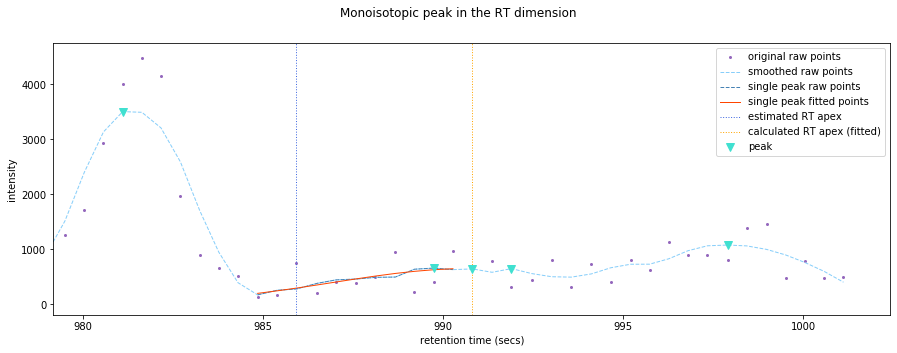

In [128]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_0_df.retention_time_secs, rt_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_0_df.retention_time_secs, rt_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_0_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_0_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_0_metrics['peak_maxima_indexes']
    ax.plot(rt_0_df.retention_time_secs.iloc[peak_idxs], rt_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Monoisotopic peak in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension, constraining the points to the FWHM of the peak in RT

In [129]:
rt_peak_fwhm_lower = rt_0_metrics['apex'] - (rt_0_metrics['full_width_half_max'])
rt_peak_fwhm_upper = rt_0_metrics['apex'] + (rt_0_metrics['full_width_half_max'])
mono_raw_points_df = mono_raw_points_df[(mono_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (mono_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [130]:
scan_0_df = mono_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_0_df['x'] = scan_0_df.scan
scan_0_metrics = fit_curve_to_flattened_isotope(scan_0_df, estimated_scan_apex, SCAN_WIDTH)

there are 4 peaks


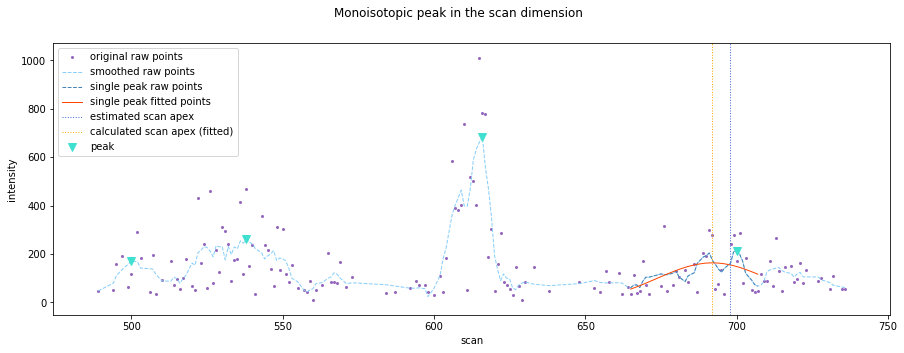

In [131]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_0_df.scan, scan_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_0_df.scan, scan_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if scan_0_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_0_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_0_metrics['peak_maxima_indexes']
    ax.plot(scan_0_df.scan.iloc[peak_idxs], scan_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Monoisotopic peak in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 1 peak

In [132]:
isotope_1_raw_points_df = isotope_raw_points_l[1]

Collapse the points onto the RT dimension

In [133]:
rt_1_df = isotope_1_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_1_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_1_df['x'] = rt_1_df.retention_time_secs
rt_1_metrics = fit_curve_to_flattened_isotope(rt_1_df, estimated_rt_apex, RT_WIDTH)

there are 3 peaks
could not find a valley above the peak


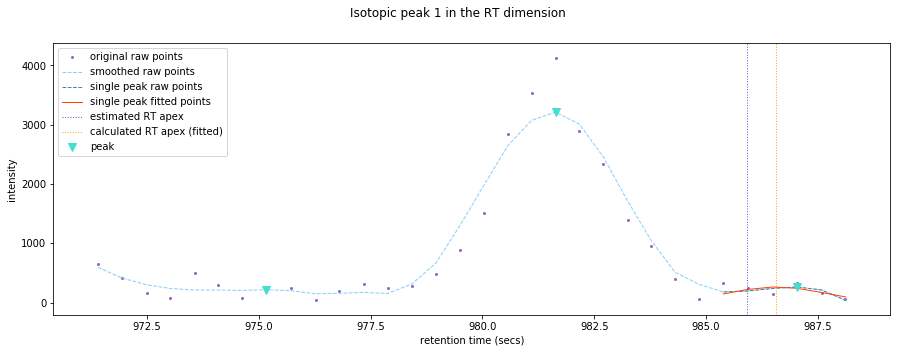

In [134]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_1_df.retention_time_secs, rt_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_1_df.retention_time_secs, rt_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_1_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_1_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_1_metrics['peak_maxima_indexes']
    ax.plot(rt_1_df.retention_time_secs.iloc[peak_idxs], rt_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 1 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [135]:
rt_peak_fwhm_lower = rt_1_metrics['apex'] - rt_1_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_1_metrics['apex'] + rt_1_metrics['full_width_half_max']
isotope_1_raw_points_df = isotope_1_raw_points_df[(isotope_1_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_1_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [136]:
scan_1_df = isotope_1_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_1_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_1_df['x'] = scan_1_df.scan
scan_1_metrics = fit_curve_to_flattened_isotope(scan_1_df, estimated_scan_apex, SCAN_WIDTH)

there are 1 peaks


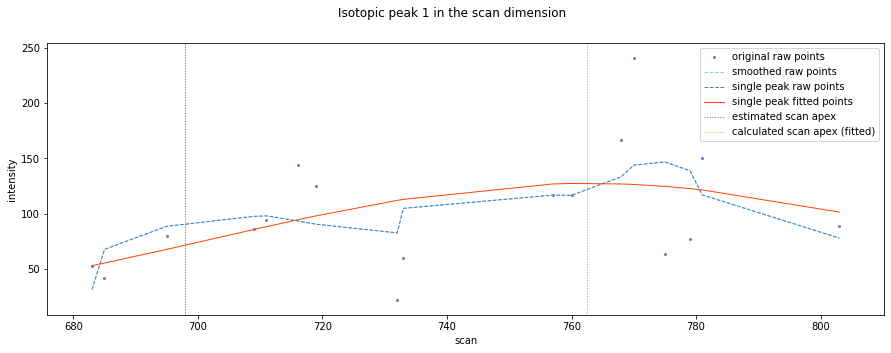

In [137]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_1_df.scan, scan_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_1_df.scan, scan_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if scan_1_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_1_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_1_metrics['peak_maxima_indexes']
    ax.plot(scan_1_df.scan.iloc[peak_idxs], scan_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 1 in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 2 peak

In [138]:
isotope_2_raw_points_df = isotope_raw_points_l[2]

Collapse the points onto the RT dimension

In [139]:
rt_2_df = isotope_2_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_2_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_2_df['x'] = rt_2_df.retention_time_secs
rt_2_metrics = fit_curve_to_flattened_isotope(rt_2_df, estimated_rt_apex, RT_WIDTH)

there are 2 peaks


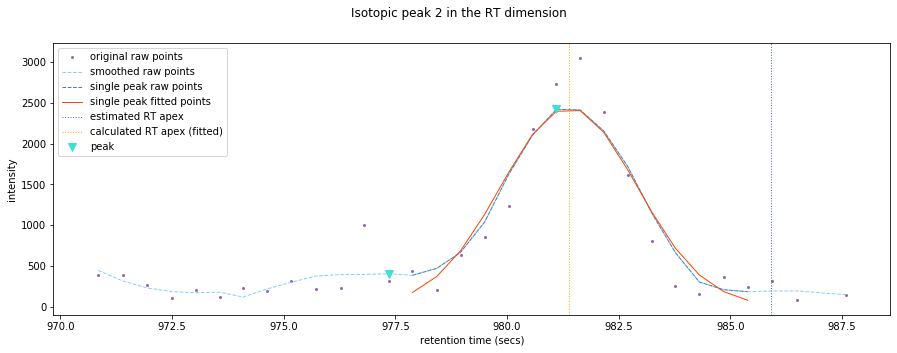

In [140]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_2_df.retention_time_secs, rt_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_2_df.retention_time_secs, rt_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_2_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_2_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_2_metrics['peak_maxima_indexes']
    ax.plot(rt_2_df.retention_time_secs.iloc[peak_idxs], rt_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 2 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [141]:
rt_peak_fwhm_lower = rt_2_metrics['apex'] - rt_2_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_2_metrics['apex'] + rt_2_metrics['full_width_half_max']
isotope_2_raw_points_df = isotope_2_raw_points_df[(isotope_2_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_2_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [142]:
scan_2_df = isotope_2_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_2_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_2_df['x'] = scan_2_df.scan
scan_2_metrics = fit_curve_to_flattened_isotope(scan_2_df, estimated_scan_apex, SCAN_WIDTH)

there are 4 peaks


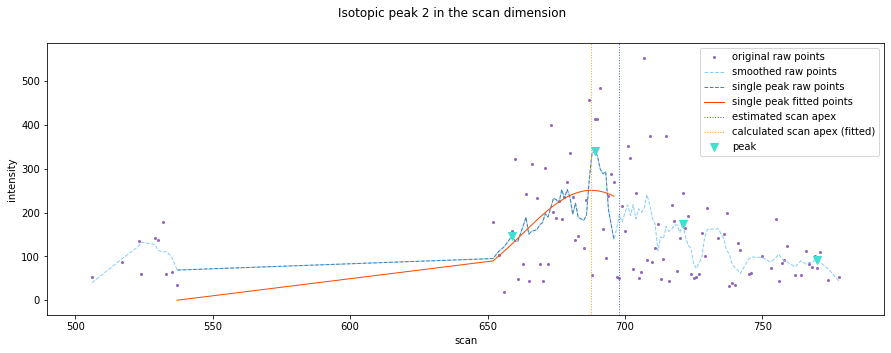

In [143]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_2_df.scan, scan_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_2_df.scan, scan_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
if scan_2_metrics['number_of_peaks'] > 0:
    # plot the fitted curve
    ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
    # show the estimated apex
    plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_2_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_2_metrics['peak_maxima_indexes']
    ax.plot(scan_2_df.scan.iloc[peak_idxs], scan_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 2 in the scan dimension')
plt.margins(0.06)
plt.show()

Calculate the isotopic peak correlation with each other in RT

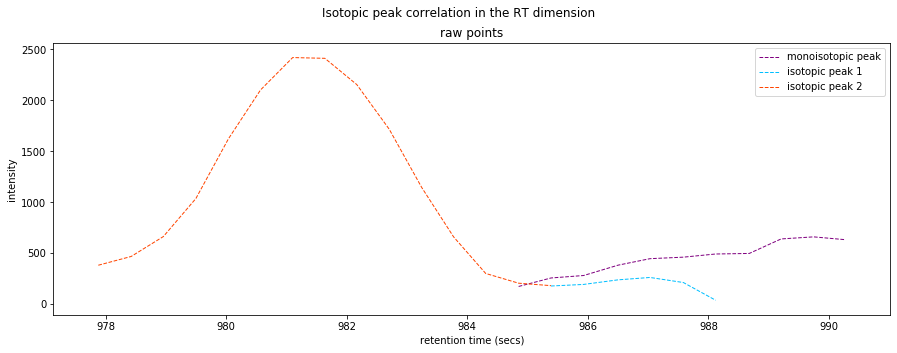

In [162]:
f, ax = plt.subplots()
ax.plot(rt_0_metrics['isolated_peak_df'].retention_time_secs, rt_0_metrics['isolated_peak_df'].filtered_intensity, marker='', color='purple', linestyle='--', linewidth=1, ms=2, label='monoisotopic peak')
ax.plot(rt_1_metrics['isolated_peak_df'].retention_time_secs, rt_1_metrics['isolated_peak_df'].filtered_intensity, marker='', color='deepskyblue', linestyle='--', linewidth=1, ms=2, label='isotopic peak 1')
ax.plot(rt_2_metrics['isolated_peak_df'].retention_time_secs, rt_2_metrics['isolated_peak_df'].filtered_intensity, marker='', color='orangered', linestyle='--', linewidth=1, ms=2, label='isotopic peak 2')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak correlation in the RT dimension')
plt.title('raw points')
plt.margins(0.06)
plt.show()